# Práctica de Machine Learning. Dataset de Airbnb


## 0.- Preliminares

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns


# Config
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None) 

### 0.1.- Identificación del tipo de problema

Como la variable objetivo es el precio del aquiler del apartamento y se trata de una variable continua, como una primera aproximación se tratará como un problema de regresión.

Scripts / Funciones de ayuda

In [2]:
def test_na_by_column(df):
    total = len(df)
    result = []
    for dfColumn in df.columns:
        result = result + [[dfColumn,(df[dfColumn].isna().sum()/total)*100 ]]
    
    print(sorted(result, key = lambda x: x[1], reverse=True))      
    
def scale_columns(df, list_columns):
    sum = 0
    for columnName in list_columns:
        sum = sum + df[columnName] * 100 / 10
    return sum / len(list_columns)

def var_important_analisys(df):
    data = df.values
    y = data[:,0:1]
    X = data[:,1:]

    feature_names = df.columns[1:]

    mi = mutual_info_regression(X, y)
    mi /= np.max(mi)

    # Tamaño de la gráfica
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(10)

    plt.subplot(1,2,2)
    plt.bar(range(X.shape[1]),mi, align="center")
    plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
    plt.xlabel('Features')
    plt.ylabel('Ranking')
    plt.title('Mutual information score')

    plt.show()
    
def graph_corr(dataf, column):
    # Compute the correlation matrix
    corr = np.abs(dataf.drop([column], axis=1).corr())

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
                linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

    plt.show()
    
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

Carga del dataset

In [3]:
full_df = pd.read_csv('./data/airbnb-listings.csv', sep=';', decimal='.')

### 0.2.- Limpieza de datos previa a la división de datos

A pesar de no ser un práctica recomendada antes de realizar la división entre train y test, se realiza una limpieza de los datos por los siguientes motivos:
   - El estudio se va a realizar sobre la ciudad de Madrid con lo cual se pueden eliminar las filas de otras ciudades.
   - Las columnas cuyo contenido es una URL no se van a ser relevantes para el modelo.
   - Eliminación de ID's internos de Airbnb
   - Eliminación de columnas/campos vacíos.

In [4]:
full_df = full_df[full_df.City == 'Madrid']

In [5]:
full_df = full_df.drop(['Listing Url', 'Host Thumbnail Url', 'Host Picture Url', 'Host URL', 'Picture Url', 'Medium Url', 'Thumbnail Url', 'XL Picture Url'], axis=1)

In [6]:
full_df = full_df.drop(['ID', 'Scrape ID', 'Host ID'], axis=1)

In [7]:
empty_cols = [col for col in full_df.columns if full_df[col].isnull().all()]
print("Columnas que se van a eliminar: ", empty_cols)
full_df = full_df.drop(empty_cols, axis=1)

Columnas que se van a eliminar:  ['Host Acceptance Rate', 'Has Availability', 'Jurisdiction Names']


In [8]:
full_df.shape

(13207, 75)

## 1.- Preparación de los datos

### 1.1.- División de los datos en Train y Test

In [9]:
df_train, df_test = train_test_split(full_df, test_size=.25, shuffle=True, random_state=0)

In [10]:
print(f'Dimensiones del dataset de training: {df_train.shape}')
print(f'Dimensiones del dataset de test: {df_test.shape}')

# Guardamos
df_train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
df_test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (9905, 75)
Dimensiones del dataset de test: (3302, 75)


### <span style="color: red">Elección del entorno</span>

In [75]:
# Valores posibles "test" y "train"
ENVIRONMENT = "test"

In [76]:
# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
if ENVIRONMENT == 'test':
    df = pd.read_csv( './data/test.csv', sep=';', decimal='.')
else: 
    df = pd.read_csv('./data/train.csv', sep=';', decimal='.')

## 2.- Análisis exploratorio

### 2.2.- Limpieza de los datos

In [77]:
df.head()

,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,2017-04-08,Cosy room&balcony close to center,I rent my room in a 5 person flatshare during ...,NaN,I rent my room in a 5 person flatshare during ...,none,NaN,NaN,NaN,NaN,NaN,NaN,Katja,2016-04-25,ES,NaN,NaN,NaN,Argüelles,1.0,1.0,"phone,facebook","Argüelles, Madrid, Comunidad de Madrid 28008, ...",Argüelles,Argüelles,Moncloa - Aravaca,Madrid,Comunidad de Madrid,28008,Madrid,"Madrid, Spain",ES,Spain,40.431285,-3.719998,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Elevator in building...",NaN,12.0,NaN,NaN,NaN,NaN,1,0,1,1125,12 months ago,0,0,0,0,2017-04-07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,1.0,NaN,"40.43128539871718, -3.7199984664263335","Host Has Profile Pic,Is Location Exact,Require..."
1,2017-04-08,En-suite quite room in Recoletos. Private bath...,"At the heart of ""Madrid's Golden Mile"" you wil...",NaN,"At the heart of ""Madrid's Golden Mile"" you wil...",none,NaN,NaN,NaN,NaN,NaN,No smoking No pets No visits from other people...,Maria,2012-08-02,"Madrid, Community of Madrid, Spain","I am from Barcelona. Lived in London, Dublin a...",within a few hours,100.0,NaN,1.0,1.0,"email,phone,reviews,jumio,offline_government_i...","Madrid, Comunidad de Madrid 28001, Spain",NaN,Recoletos,Salamanca,Madrid,Comunidad de Madrid,28001,Madrid,"Madrid, Spain",ES,Spain,40.420817,-3.690687,House,Private room,2,2.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,37.0,NaN,NaN,90.0,19.0,1,9,3,90,today,23,47,77,77,2017-04-08,4,2016-05-23,2017-01-12,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,flexible,1.0,0.37,"40.42081743500131, -3.690686958002691","Host Has Profile Pic,Host Identity Verified,Re..."
2,2017-04-08,Apartamento en Malasaña,¡Hola! Alquilo mi apartamento en pleno centro ...,NaN,¡Hola! Alquilo mi apartamento en pleno centro ...,none,NaN,NaN,NaN,NaN,NaN,NaN,Paloma,2013-07-03,"Madrid, Community of Madrid, Spain",NaN,within an hour,100.0,Malasaña,1.0,1.0,"phone,reviews","Malasaña, Madrid, Comunidad de Madrid 28004, S...",Malasaña,Universidad,Centro,Madrid,Comunidad de Madrid,28004,Madrid,"Madrid, Spain",ES,Spain,40.428787,-3.704170,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Smoking allowed,E...",NaN,50.0,NaN,NaN,NaN,NaN,1,0,2,15,3 weeks ago,0,0,0,0,2017-04-08,5,2016-11-14,2017-03-20,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,strict,1.0,1.03,"40.42878678711801, -3.704169764129888","Host Has Profile Pic,Is Location Exact,Require..."
3,2017-04-08,"Place&Price: SOL area, 70m2, 2 rooms, Wifi, XBOX",Amazing location. In the heart of Madrid. C/ A...,Amazing location. In the heart of Madrid. C / ...,Amazing location. In the heart of Madrid. C/ A...,none,"All roads lead to the ""Puerta del Sol"" - liter...",We have a flexible check in and out but it dep...,"Metro (subway): Sol (Lines 1, 2 and 3). Exits:...","WIFI, available robotic parking 15 minutes wal...",NaN,First of all we hope you have a wond

Los campos siguientes se considera que no aportan información para el estudio:
   - Name
   - Summary
   - Space
   - Description
   - House Rules
   - Interaction
   - Host About
   - Notes
   - Host Name
   - Neighborhood Overview
   - Access
   - License
   

In [78]:
df = df.drop(['Name', 'Summary', 'Space', 'Description', 'House Rules', 'Interaction', 'Host About', 'Notes', 'Host Name', 'Access', 'Neighborhood Overview', 'License'], axis=1)

Se sospecha que ciertos campos pueden contener valores iguales.

In [79]:
df['Smart Location'].value_counts()

Madrid, Spain     3300
Madrid , Spain       2
Name: Smart Location, dtype: int64

In [80]:
df['Last Scraped'].value_counts()

2017-04-08    3302
Name: Last Scraped, dtype: int64

In [81]:
df['Experiences Offered'].value_counts()

none    3302
Name: Experiences Offered, dtype: int64

In [82]:
df['Calendar last Scraped'].value_counts()

2017-04-08    2374
2017-04-07     928
Name: Calendar last Scraped, dtype: int64

In [83]:
df = df.drop(['Smart Location','Last Scraped', 'Calendar last Scraped', 'Experiences Offered'], axis=1)

Los campos "Market, State, Host Location, City, Country Code, Country" hacen referencia a la ciudad, como el estudio es sobre "Madrid" no aportan información al modelo.

In [84]:
df = df.drop(['Market', 'State', 'Host Location', 'City', 'Country Code', 'Country'], axis=1)

In [85]:
df.head().T

,0,1,2,3,4
Transit,NaN,NaN,NaN,"Metro (subway): Sol (Lines 1, 2 and 3). Exits:...",NaN
Host Since,2016-04-25,2012-08-02,2013-07-03,2013-04-14,2011-09-30
Host Response Time,NaN,within a few hours,within an hour,within an hour,within an hour
Host Response Rate,NaN,100.0,100.0,100.0,100.0
Host Neighbourhood,Argüelles,NaN,Malasaña,Sol,Malasaña
Host Listings Count,1.0,1.0,1.0,3.0,1.0
Host Total Listings Count,1.0,1.0,1.0,3.0,1.0
Host Verifications,"phone,facebook","email,phone,reviews,jumio,offline_government_i...","phone,reviews","email,phone,reviews,jumio","email,phone,reviews,jumio,offline_government_i..."
Street,"Argüelles, Madrid, Comunidad de Madrid 28008, ...","Madrid, Comunidad de Madrid 28001, Spain","Malasaña, Madrid, Comunidad de Madrid 28004, S...","Sol, Madrid, Madrid 28013, Spain","Malasaña, Madrid, Comunidad de Madrid 28004, S..."
Neighbourhood,Argüelles,NaN,Malasaña,Sol,Malasaña


Se decide eliminar la columna "Transit" que se usa para indicar el Transporte cercano que podría afectar en el precio, pero al ser un campo de texto libre es muy dificil de sacar conclusiones sobre el mismo.  

In [86]:
df = df.drop(['Transit'], axis=1)

Otra variables / columnas que se interpretan que no tienen relevancia son las relativas al anfitrion.

In [87]:
df = df.drop(['Host Since', 'Host Response Rate', 'Host Response Time', 'Host Neighbourhood', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count', 'Host Verifications', 'Calculated host listings count'], axis=1)

La variable Geolocation es la concatenación de Latitude y Longitude.

In [88]:
df = df.drop(['Geolocation'], axis=1)

La variable Neighbourhood contiene información equivalente a la varibale Neighbourhood Cleansed, con lo cual se decide utilizar esta última.

In [89]:
df = df.drop(['Neighbourhood'], axis=1)

Revisando los valores de las variables de texto para ver si se puede realizar algún tipo de codificación lógica.

In [90]:
print('Nº de valores distintos en: ')
textColumns = df.select_dtypes(include = 'object').columns
for dfVar in textColumns:
    print(f'\t {dfVar}: ', len(df[dfVar].value_counts()))
    

Nº de valores distintos en: 
	 Street:  382
	 Neighbourhood Cleansed:  118
	 Neighbourhood Group Cleansed:  21
	 Zipcode:  57
	 Property Type:  18
	 Room Type:  3
	 Bed Type:  4
	 Amenities:  3050
	 Calendar Updated:  47
	 First Review:  996
	 Last Review:  425
	 Cancellation Policy:  4
	 Features:  50


El campo de texto Street, se observa que tiene muchas variantes y además su información está muy relacionada con el barrio. 

In [91]:
df = df.drop(['Street'], axis=1)

La bariable "Calendar Updated" hace referencia a la ultima actualizacion de la disponiblidad y no se considera relevante para el modelo

In [92]:
df = df.drop(['Calendar Updated'], axis=1)

Los campos referentes a la disponiblidad o Availability no se considera que puedan afectar al precio

In [93]:
# df = df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Availability 365'], axis=1)

Fecha de la primera y ultima review no se consideran relevantes

In [94]:
df = df.drop(['First Review', 'Last Review'], axis=1)

In [95]:
df.head().T

,0,1,2,3,4
Neighbourhood Cleansed,Argüelles,Recoletos,Universidad,Sol,Universidad
Neighbourhood Group Cleansed,Moncloa - Aravaca,Salamanca,Centro,Centro,Centro
Zipcode,28008,28001,28004,28013,28004
Latitude,40.431285,40.420817,40.428787,40.416087,40.425978
Longitude,-3.719998,-3.690687,-3.70417,-3.706012,-3.704761
Property Type,Apartment,House,Apartment,Apartment,Apartment
Room Type,Private room,Private room,Entire home/apt,Entire home/apt,Entire home/apt
Accommodates,1,2,3,5,4
Bathrooms,1.0,2.0,1.0,1.0,2.0
Bedrooms,1.0,1.0,1.0,2.0,2.0


In [96]:
df.shape

(3302, 38)

### 2.3.- Missing values

Ver el porcentaje de NA por columna

In [97]:
test_na_by_column(df)

[['Square Feet', 95.91156874621441], ['Monthly Price', 76.22652937613567], ['Weekly Price', 76.13567534827376], ['Security Deposit', 57.207752877044214], ['Cleaning Fee', 40.09691096305269], ['Review Scores Checkin', 20.533010296789826], ['Review Scores Location', 20.533010296789826], ['Review Scores Value', 20.533010296789826], ['Review Scores Accuracy', 20.47244094488189], ['Review Scores Cleanliness', 20.47244094488189], ['Review Scores Rating', 20.411871592973956], ['Review Scores Communication', 20.411871592973956], ['Reviews per Month', 19.412477286493036], ['Zipcode', 3.422168382798304], ['Amenities', 0.8782556026650515], ['Bathrooms', 0.24227740763173833], ['Bedrooms', 0.15142337976983647], ['Beds', 0.12113870381586916], ['Price', 0.12113870381586916], ['Neighbourhood Cleansed', 0.0], ['Neighbourhood Group Cleansed', 0.0], ['Latitude', 0.0], ['Longitude', 0.0], ['Property Type', 0.0], ['Room Type', 0.0], ['Accommodates', 0.0], ['Bed Type', 0.0], ['Guests Included', 0.0], ['Extr

Aunque el campo "Square Feet" se sopecha que puede ser importante para el modelo que estamos estudiando, contiene más de un 95% de NAN. Pasa algo similar con las variables Monthly Price, Weekly Price. Se eliminan.

In [98]:
# df = df.drop(['Square Feet', 'Monthly Price', 'Weekly Price'], axis=1)
df = df.drop(['Square Feet'], axis=1)

Como primera medida se decide eliminar las filas con NAN en las columnas cuya cantidad de NAN es inferior al 1%. Son pocos registros y tendrá poco impacto.

In [99]:
total = len(df)
result = []
for dfColumn in df.columns:
    percentNAN = df[dfColumn].isna().sum()/total
    if 0.0 < percentNAN < 0.01:
        result = result + [[dfColumn,df[dfColumn].isna().sum()/total]]
df[[row[0] for row in result]].isna().sum()

Bathrooms     8
Bedrooms      5
Beds          4
Amenities    29
Price         4
dtype: int64

In [100]:
rowsWIthLowNa = [ 'Bathrooms', 'Bedrooms', 'Amenities', 'Beds', 'Price' ]
for dfVar in rowsWIthLowNa:
    df = df[df[dfVar].notna()]

In [101]:
df.shape

(3259, 37)

Se considera que los valores NA de las columnas 'Security Deposit' y 'Cleaning Fee' serían equivalentes a 0, o lo que es lo mismo, no tienen Fianza ni Tarifa de limpieza.

In [102]:
df['Security Deposit'] = df['Security Deposit'].fillna(0)
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

El campo Zipcode se van a rellenar con la moda ya que tiene relacion con el barrio:

In [103]:
groups = df.groupby('Neighbourhood Cleansed')

mode_zipcode = groups['Zipcode'].transform(lambda x: x.mode()[0])    
df['Zipcode'] = df['Zipcode'].fillna(mode_zipcode)

In [104]:
df.isna().sum()

Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
Zipcode                            0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                          0
Bedrooms                           0
Beds                               0
Bed Type                           0
Amenities                          0
Price                              0
Weekly Price                    2482
Monthly Price                   2487
Security Deposit                   0
Cleaning Fee                       0
Guests Included                    0
Extra People                       0
Minimum Nights                     0
Maximum Nights                     0
Availability 30                    0
Availability 60                    0
Availability 90                    0
Availability 365                   0
Number of Reviews                  0
R

Se hace una estimacion de lo que saldría el precio por día y se rellena con la media.

In [105]:
# df['day_price'] = np.where(df['Weekly Price'].isna(), df['Monthly Price'] / 30, df['Weekly Price'] / 7)
df['day_price_by_week'] = df['Weekly Price'] / 7
df['day_price_by_month'] = df['Monthly Price'] / 30
# df = df.drop(['Weekly Price','Monthly Price' ], axis=1)


In [106]:
# df['day_price'] = df['day_price'].fillna(df['day_price'].mean())
df['day_price_by_week'] = df['day_price_by_week'].fillna(df['Price'].mean())
df['day_price_by_month'] = df['day_price_by_month'].fillna(df['Price'].mean())



In [107]:
df = df.drop(['Monthly Price', 'Weekly Price'], axis=1)

Las variables "Review..." Se rellenan los NA con la media de cada columna.

In [108]:
columns_to_fill = ['Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Reviews per Month']
 
for varColumn in columns_to_fill:
    df[varColumn] = df[varColumn].fillna(df[varColumn].mean())

In [109]:
df.isna().sum()

Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Zipcode                         0
Latitude                        0
Longitude                       0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Amenities                       0
Price                           0
Security Deposit                0
Cleaning Fee                    0
Guests Included                 0
Extra People                    0
Minimum Nights                  0
Maximum Nights                  0
Availability 30                 0
Availability 60                 0
Availability 90                 0
Availability 365                0
Number of Reviews               0
Review Scores Rating            0
Review Scores Accuracy          0
Review Scores Cleanliness       0
Review Scores Checkin           0
Review Scores 

### 2.4.- Transformación de variables

Las variables Amenities y Features, se decide transformaralas con el número de elementos que contienen

In [110]:
df['Amenities'] = df['Amenities'].str.count(',') + 1

In [111]:
df['Features'] = df['Features'].str.count(',') + 1

### 2.2.- Outliers

In [112]:
df.describe()

,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,Features,day_price_by_week,day_price_by_month
count,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000
mean,40.420410,-3.697760,3.273397,1.258822,1.304695,2.042037,14.503529,66.825407,80.231973,17.993556,1.623197,7.557226,3.306229,1154.861307,8.691930,22.866830,39.917766,204.670758,23.787665,91.715161,9.412644,9.330268,9.639187,9.663093,9.538344,9.216641,1.955564,3.776619,63.213940,61.621669
std,0.019893,0.023255,2.093092,0.582625,0.835896,1.599881,4.526123,56.885445,118.370978,24.804768,1.165981,9.385674,21.505894,17511.307949,8.846947,19.280332,29.123348,126.603990,37.013507,7.796878,0.803343,0.880403,0.660067,0.653066,0.710823,0.839955,1.730981,1.052253,14.522927,17.479537
min,40.331888,-3.819501,1.000000,0.000000,0.000000,1.000000,1.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.020000,1.000000,10.714286,8.666667
25%,40.410104,-3.708011,2.000000,1.000000,1.000000,1.000000,11.000000,30.000000,0.000000,0.000000,1.000000,0.000000,1.000000,365.000000,0.000000,5.000000,13.000000,84.000000,1.000000,90.000000,9.000000,9.000000,9.639187,9.663093,9.000000,9.000000,0.630000,3.000000,66.825407,66.825407
50%,40.419127,-3.701952,3.000000,1.000000,1.000000,2.000000,14.000000,53.000000,0.000000,12.000000,1.000000,5.000000,2.000000,1125.000000,7.000000,20.000000,38.000000,243.000000,8.000000,92.000000,9.412644,9.330268,10.000000,10.000000,10.000000,9.216641,1.950000,4.000000,66.825407,66.825407
75%,40.428004,-3.694475,4.000000,1.000000,2.000000,2.000000,17.000000,80.000000,150.000000,30.000000,2.000000,15.000000,3.000000,1125.000000,14.000000,38.000000,65.000000,321.000000,30.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.425000,4.000000,66.825407,66.825407
max,40.514247,-3.575142,16.000000,6.000000,10.000000,16.000000,31.000000,750.000000,950.000000,300.000000,12.000000,100.000000,1125.000000,1000000.000000,30.000000,60.000000,90.000000,365.000000,343.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,17.210000,8.000000,135.714286,233.000000


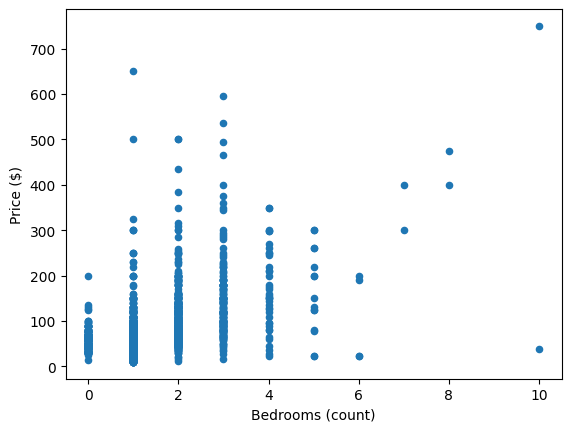

In [113]:
df.plot(kind = 'scatter',x='Bedrooms',y = 'Price')
plt.xlabel('Bedrooms (count)')
plt.ylabel('Price ($)')
plt.show()

Se eliminan los apartamentos que contengan mas de 8 habitaciones y un precio menor de 300

In [114]:
df = df.drop(df[(df['Bedrooms'] > 7) & (df['Price'] < 300)].index)

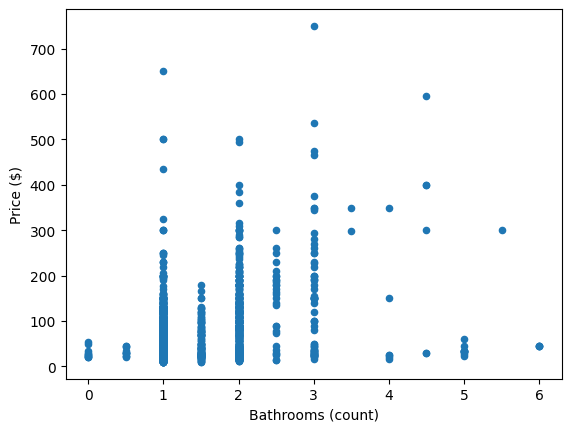

In [115]:
df.plot(kind = 'scatter',x='Bathrooms',y = 'Price')
plt.xlabel('Bathrooms (count)')
plt.ylabel('Price ($)')
plt.show()

Se elimina los apartamentos con más de 7 baños y un precio indeferior a 200.

In [116]:
df = df.drop(df[(df['Bathrooms'] > 7) & (df['Price'] < 200)].index)

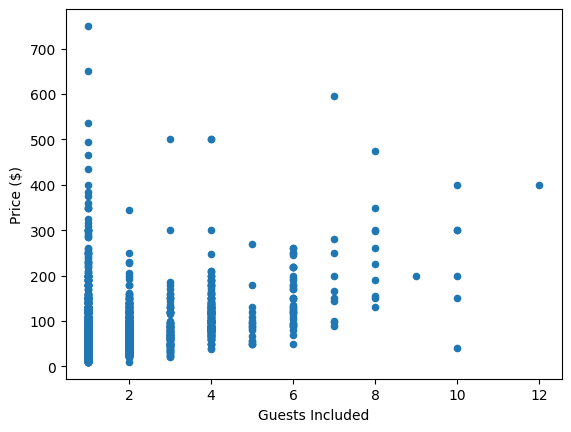

In [117]:
df.plot(kind = 'scatter',x='Guests Included',y = 'Price')
plt.xlabel('Guests Included')
plt.ylabel('Price ($)')
plt.show()

No se decide eliminar los precios bajos con muchas personas porque se piensa que se podría tratar de Albergues.

<AxesSubplot: title={'center': 'Price'}, xlabel='Room Type'>

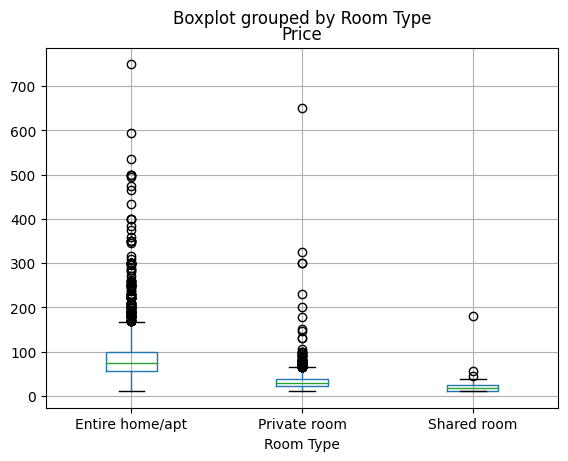

In [118]:
df.boxplot(by='Room Type',column = 'Price')

### 2.4.- Codificación de variables

In [119]:
df.dtypes

Neighbourhood Cleansed           object
Neighbourhood Group Cleansed     object
Zipcode                          object
Latitude                        float64
Longitude                       float64
Property Type                    object
Room Type                        object
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                         object
Amenities                         int64
Price                           float64
Security Deposit                float64
Cleaning Fee                    float64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Maximum Nights                    int64
Availability 30                   int64
Availability 60                   int64
Availability 90                   int64
Availability 365                  int64
Number of Reviews                 int64


In [120]:
df['Cancellation Policy'].value_counts()

strict             1232
moderate           1026
flexible            999
super_strict_60       1
Name: Cancellation Policy, dtype: int64

In [121]:
df['Bed Type'].value_counts()

Real Bed         3185
Pull-out Sofa      65
Futon               6
Couch               2
Name: Bed Type, dtype: int64

In [122]:
df['Room Type'].value_counts()

Entire home/apt    1943
Private room       1268
Shared room          47
Name: Room Type, dtype: int64

In [123]:
categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Zipcode', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

mean_map = {}
for c in categorical:
    mean = df.groupby(c)['Price'].mean()
    df[c] = df[c].map(mean)    
    mean_map[c] = mean

In [124]:
df.dtypes

Neighbourhood Cleansed          float64
Neighbourhood Group Cleansed    float64
Zipcode                         float64
Latitude                        float64
Longitude                       float64
Property Type                   float64
Room Type                       float64
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                        float64
Amenities                         int64
Price                           float64
Security Deposit                float64
Cleaning Fee                    float64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Maximum Nights                    int64
Availability 30                   int64
Availability 60                   int64
Availability 90                   int64
Availability 365                  int64
Number of Reviews                 int64


In [125]:
df.isna().sum()

Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Zipcode                         0
Latitude                        0
Longitude                       0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Amenities                       0
Price                           0
Security Deposit                0
Cleaning Fee                    0
Guests Included                 0
Extra People                    0
Minimum Nights                  0
Maximum Nights                  0
Availability 30                 0
Availability 60                 0
Availability 90                 0
Availability 365                0
Number of Reviews               0
Review Scores Rating            0
Review Scores Accuracy          0
Review Scores Cleanliness       0
Review Scores Checkin           0
Review Scores 

### 2.3.- Correlación

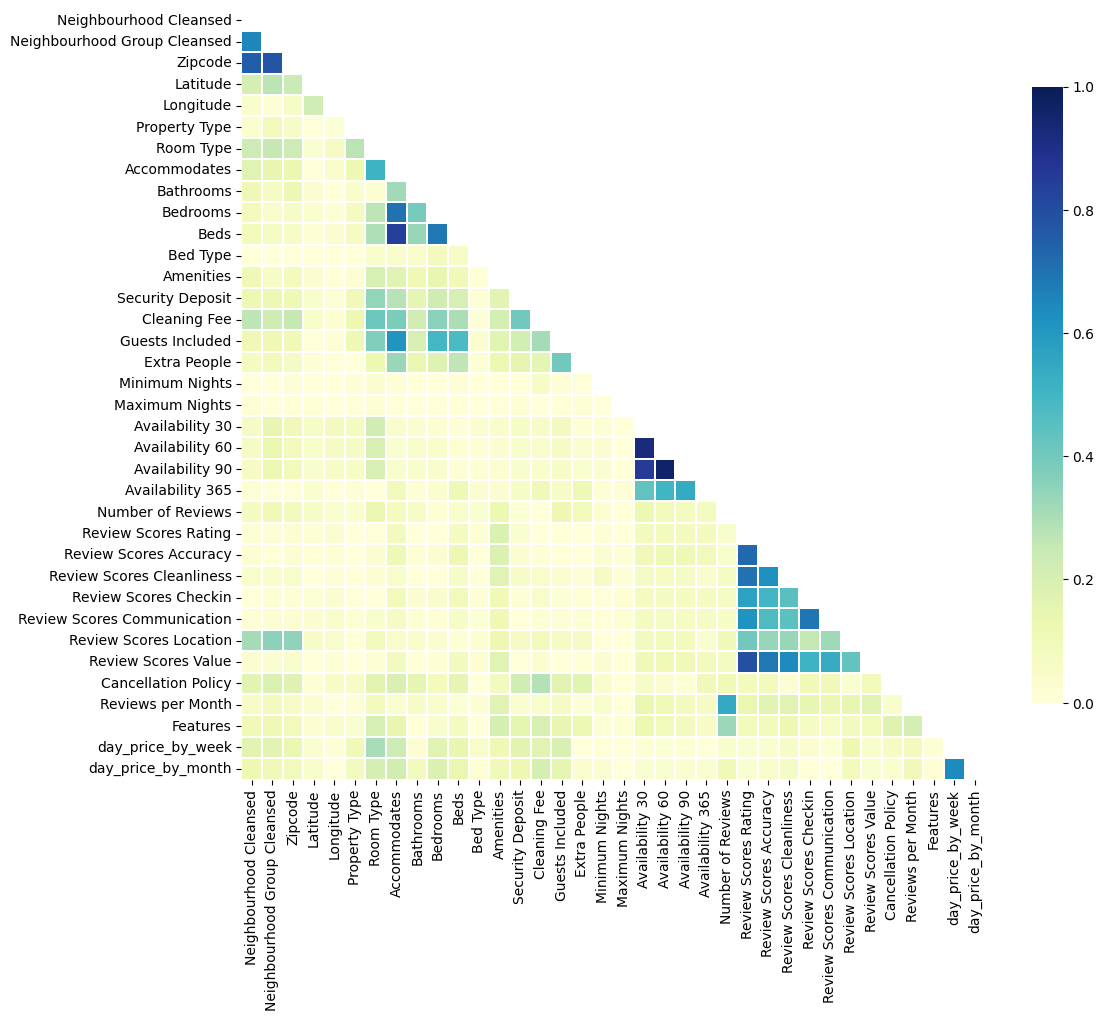

In [126]:
graph_corr(df, 'Price')

Se observan las siguientes relaciones entre variables:
   - Neighbourhood Cleansed, Neighbourhood Group Cleansed, ZipCode -> Todas hacen refencia a la zona.
   - Bathrooms, Bedrooms, Beds, Accommodates -> Determinará la capacidad del apartamento
       - Con Cleaning Fee -> A mayor número de personas, habitaciones y baños mayor será la cuota de limpieza
       - Con Guest Included -> A mayor capacidad más personas incluidas en la reserva
   - Campos Review, los importantes serían "Review Scores Rating" y "Review Scores Accuracy"

In [127]:
if ENVIRONMENT == 'train':
    pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'hist')
    plt.show()

## 3.- Preprocesamiento

### 3.1.- Ordenación de las variables

In [128]:
# Ordenacion de las columnas
df.columns
priceIndex = df.columns.get_loc("Price")
restIndex = list(range(0, priceIndex)) + list(range(priceIndex+1, len(df.columns)))
df = df.iloc[:, [priceIndex] + restIndex]
df.columns

Index(['Price', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
       'Zipcode', 'Latitude', 'Longitude', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Cancellation Policy', 'Reviews per Month',
       'Features', 'day_price_by_week', 'day_price_by_month'],
      dtype='object')

## 4.- Modelado

In [129]:
df.shape

(3258, 37)


### 4.1.- Cross validation

In [130]:
data = df.values
X = data[:,1:]   # nos quedamos con la 1ª columna, price
y = data[:,0:1]  # nos quedamos con el resto
feature_names = df.columns[1:]

if ENVIRONMENT == 'train':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

    # Escalamos (con los datos de train)
    scaler = preprocessing.StandardScaler().fit(X_train)
    XtrainScaled = scaler.transform(X_train)
    XtestScaled = scaler.transform(X_test)

    print('Datos entrenamiento: ', X_train.shape)
    print('Datos test: ', X_test.shape)

Se aplica Lasso para seleccionar las variables mas y menos relevantes para el modelo

In [131]:
if ENVIRONMENT == 'train':
    alpha_vector = np.logspace(-1,10,50)
    param_grid_lasso = {'alpha': alpha_vector }
    grid_lasso = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid_lasso, cv = 10)
    grid_lasso.fit(XtrainScaled, y_train)
    print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
    print("best parameters: {}".format(grid_lasso.best_params_))

    #-1 porque es negado
    scores = -1*np.array(grid_lasso.cv_results_['mean_test_score'])
    plt.semilogx(alpha_vector,scores,'-o')
    plt.xlabel('alpha',fontsize=16)
    plt.ylabel('5-Fold MSE')
    plt.show()
    df.shape

Métricas. Selección de variables aplicando Lasso

In [132]:
if ENVIRONMENT == 'train':
    alpha_optimo = grid_lasso.best_params_['alpha']
    lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

    ytrainLasso = lasso.predict(XtrainScaled)
    ytestLasso  = lasso.predict(XtestScaled)
    mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
    mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

    print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
    print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

    print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
    print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

    w = lasso.coef_

    print("\nVariables relevantes:")
    for f,wi in zip(feature_names,w):
        if (wi > 0):
            print(f,wi)

    print("\nVariables NO relevantes:")
    for f,wi in zip(feature_names,w):
        if (wi < 0):
            print(f,wi)

### 4.2.- Eliminación de variables

Por correlacion

In [133]:
df = df.drop(['Availability 60', 'Availability 90'], axis=1)

Por Lasso

In [134]:
# df = df.drop(['Neighbourhood Group Cleansed', 'Cancellation Policy', 'Features', 'Minimum Nights' , 'Maximum Nights','Amenities','Property Type', 'Latitude', 'Security Deposit', 'Extra People', 'Number of Reviews'], axis=1)

df.head()
df = df.drop(['Latitude', 'Extra People',  
              'Number of Reviews', 'Review Scores Checkin', 
              'Review Scores Communication', 'Review Scores Location', 
              'Cancellation Policy', 'Reviews per Month'], axis=1)

# df = df.drop(['Extra People', 'Cancellation Policy', 'Features', 'day_price_by_month', 'Number of Reviews'], axis=1)


### 4.3.- Modelo con Árboles de decisión.

In [135]:
if ENVIRONMENT == 'train':
    maxDepth = range(1,10)
    param_grid = {'max_depth': maxDepth }
    grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10, verbose=1)
    grid.fit(XtrainScaled, y_train)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))

    scores = np.array(grid.cv_results_['mean_test_score'])
    plt.plot(maxDepth,scores,'-o')
    plt.xlabel('max_depth',fontsize=16)
    plt.ylabel('10-Fold MSE')
    plt.show()

    maxDepthOptimo = grid.best_params_['max_depth'] # son 11
    treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

    print("Train: ",treeModel.score(X_train,y_train))
    print("Test: ",treeModel.score(X_test,y_test))

### 4.3.- Evaluación.

Probando con el subconjunto de test obtenido de la validacion cruzada.

In [136]:
if ENVIRONMENT == "train":
    print("Test: ",treeModel.score(X_test,y_test))
    predictions = treeModel.predict(X_test)

Modificado la constante declarada arriba (Indicado en rojo), ENVIRONMENT por "test", se lanza todo el estudio sobre los datos de test.
    

In [137]:
if ENVIRONMENT == "test":
    print("Test: ",treeModel.score(X,y))
    predictions = treeModel.predict(X)

Test:  0.4105726111689233


In [138]:
# Calculo del error cometido
resultado = abs(y - predictions)
resultado.mean()

47.44861654993108

## 5.- Conclusión

Los resultados obtenidos no son nada buenos, habría que revisar con otros modelos distintos a los utilizados en este estudio. En el caso de obtener unos resultados similares, se tendría que revisar a ver si se han eliminado columnas significativas o bien intentar generar alguna variable nueva que mejore el modelo.

Por otro lado la calidad de los datos puede que este afectando ya que faltan bastantes valores en columnas que podrían ser relevantes como por ejemplo "Square Feet", "Week Price" o "Monthly Price".